# Step-by-step: Write your own neural networks with `pytorch`

In [1]:
# load data
import numpy as np
import joblib
flux, flux_err,labels = joblib.load("data.bz2")
flux[~np.isfinite(flux)] = 0
flux[flux > 2] = 2
flux[flux < 0] = 0
labels[:,0] /= 1000

Text(0, 0.5, 'logg/dex')

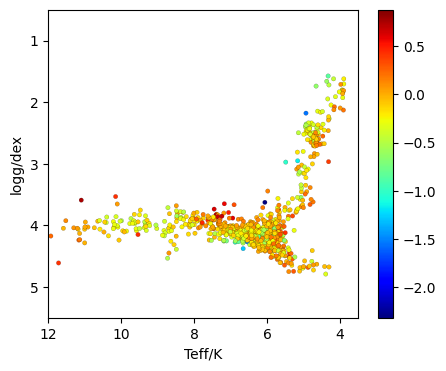

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
plt.scatter(labels[:, 0], labels[:, 1], s=10, c=labels[:, 2], cmap=plt.cm.jet, edgecolor="k", lw=.1)
plt.colorbar()
plt.xlim(12, 3.5)
plt.ylim(5.5, 0.5)
plt.xlabel("Teff/K")
plt.ylabel("logg/dex")

In [3]:
import torch
import torch.nn as nn

In [4]:
# convert to tensor
flux_tensor = torch.from_numpy(flux.astype(np.float32))
flux_err_tensor = torch.from_numpy(flux_err.astype(np.float32))
labels_tensor = torch.from_numpy(labels.astype(np.float32))
flux_tensor.size(), labels_tensor.size(), flux_tensor.dtype, labels_tensor.dtype

(torch.Size([913, 1500]), torch.Size([913, 3]), torch.float32, torch.float32)

## data loader

In [5]:
def data_loader(*args, f_train=0.7, batch_size=50, train=True):
    n_data = len(args[0])
    n_train = int(n_data * f_train)
    
    # shuffle data
    index = np.arange(0, n_data, dtype=int)
    # np.random.seed(0)
    np.random.shuffle(index)
        
    if train:
        # get training set
        for i in range(0, n_train, batch_size):
            yield (_[index[i:min(i + batch_size, n_train)]] for _ in args)
    else:
        # get test set
        for i in range(n_train, n_data, batch_size):
            yield (_[index[i:min(i + batch_size, n_data)]] for _ in args)

print("get training set")    
for x, y in data_loader(flux_tensor, labels_tensor, train=True):
    print(x.size(), y.size())
    
print("get training set")    
for x, y in data_loader(flux_tensor, labels_tensor, train=False):
    print(x.size(), y.size())

get training set
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([39, 1500]) torch.Size([39, 3])
get training set
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([50, 1500]) torch.Size([50, 3])
torch.Size([24, 1500]) torch.Size([24, 3])


In [6]:
# constants
NPIX = 1500
NLBL = 3
BS = 50

## 1. Backward model (Multi-Layer Perceptron)

$(T_\mathrm{eff}, \log{g}, \mathrm{[Fe/H]}) = f(F_\lambda)$

In [7]:
mlp = nn.Sequential(
    nn.BatchNorm1d(num_features=NPIX),
    nn.Linear(in_features=NPIX, out_features=100),
    nn.BatchNorm1d(num_features=100),
    nn.Tanh(),
    nn.Linear(in_features=100, out_features=3),
)
mlp

Sequential(
  (0): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=1500, out_features=100, bias=True)
  (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Tanh()
  (4): Linear(in_features=100, out_features=3, bias=True)
)

# train the model

In [8]:
def train(data, model, lr=1e-4, n_epoch=100, batch_size=50, step=10):
    training_loss_history = []
    test_loss_history = []
    
    loss_fn = nn.L1Loss()
    optimizer = torch.optim.RAdam(model.parameters(), lr=1e-4)
    
    for i_epoch in range(n_epoch):
        # in each epoch
        training_data_counts = 0
        training_loss_value = 0
        for batch_X, batch_y in data_loader(*data, batch_size=batch_size, train=True):
            # for each batch
            model.zero_grad()
            batch_y_pred = model(batch_X)
            batch_loss = loss_fn(batch_y_pred, batch_y)
            training_data_counts += len(batch_X)
            training_loss_value += batch_loss.detach() * training_data_counts
            # print(batch_loss.detach())
            batch_loss.backward()
            optimizer.step()
            #print(batch_loss)
        training_loss_history.append(training_loss_value / training_data_counts)
        
        with torch.no_grad():
            test_data_counts = 0
            test_loss_value = 0
            for batch_X, batch_y in data_loader(*data, batch_size=batch_size, train=False):
                batch_y_pred = model(batch_X)
                batch_loss = loss_fn(batch_y_pred, batch_y)
                test_data_counts += len(batch_X)
                test_loss_value += batch_loss.detach() * test_data_counts
            test_loss_history.append(test_loss_value / test_data_counts)
        if i_epoch % step == 0:
            print(f"Epoch {i_epoch:05d}: training loss = {training_loss_history[-1]}, test loss = {test_loss_history[-1]}")
    plt.figure(figsize=(6, 4))
    plt.plot(np.log10(training_loss_history), label="training loss")
    plt.plot(np.log10(test_loss_history), label="test loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("log10(loss)")
    return training_loss_history, test_loss_history

Epoch 00000: training loss = 25.34716033935547, test loss = 13.181946754455566
Epoch 00010: training loss = 22.91025161743164, test loss = 11.991747856140137
Epoch 00020: training loss = 21.521034240722656, test loss = 11.400087356567383
Epoch 00030: training loss = 20.80483055114746, test loss = 11.116976737976074
Epoch 00040: training loss = 20.03183937072754, test loss = 10.396178245544434
Epoch 00050: training loss = 19.066469192504883, test loss = 10.180129051208496
Epoch 00060: training loss = 17.61538314819336, test loss = 9.185478210449219
Epoch 00070: training loss = 16.54970359802246, test loss = 8.798020362854004
Epoch 00080: training loss = 15.427532196044922, test loss = 7.792622089385986
Epoch 00090: training loss = 13.849226951599121, test loss = 7.3750739097595215
Epoch 00100: training loss = 13.254377365112305, test loss = 6.905029773712158
Epoch 00110: training loss = 12.02064323425293, test loss = 6.525891304016113
Epoch 00120: training loss = 11.262432098388672, tes

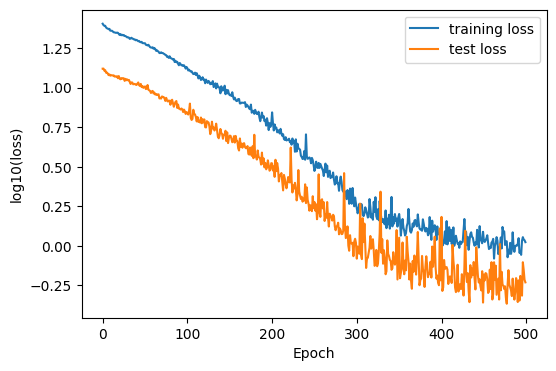

In [9]:
train_loss, test_loss = train(data=(flux_tensor, labels_tensor), model=mlp, n_epoch=500, step=10)

In [10]:
# try a spectrum
mlp.eval()
flux_tensor[:5], mlp(flux_tensor[:5]), labels_tensor[:5]

(tensor([[0.9585, 0.9763, 1.0062,  ..., 1.0039, 0.9919, 0.9863],
         [0.9110, 0.9736, 0.9935,  ..., 1.0064, 1.0046, 0.9816],
         [0.9313, 0.9506, 0.9774,  ..., 1.0107, 1.0078, 1.0023],
         [0.9774, 0.9849, 0.9753,  ..., 0.9984, 0.9987, 1.0043],
         [0.9469, 0.9893, 0.9945,  ..., 0.9987, 0.9937, 0.9898]]),
 tensor([[ 5.9303,  4.2663, -0.3450],
         [ 4.6869,  3.5767,  0.1109],
         [ 4.2853,  2.1361, -0.2646],
         [10.0050,  4.1998, -0.2836],
         [ 7.1813,  4.4121, -0.7709]], grad_fn=<AddmmBackward0>),
 tensor([[ 5.8511,  4.1560, -0.3500],
         [ 5.0626,  3.6950,  0.1340],
         [ 4.2958,  2.2680, -0.3680],
         [ 9.8520,  4.0940, -0.2570],
         [ 6.6392,  4.2710, -0.8620]]))

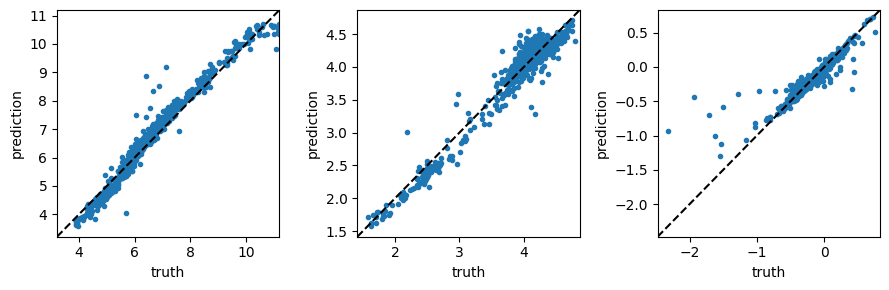

In [11]:
def compare_labels(x1, x2):
    ndim = x1.shape[1]
    fig, axs = plt.subplots(1, ndim, figsize=(3*ndim, 3))
    for idim in range(ndim):
        axs[idim].plot(x1[:, idim], x2[:, idim], '.')
        _xlim = axs[idim].get_xlim()
        _ylim = axs[idim].get_ylim()
        _lim = min(_xlim[0], _ylim[0]), min(_xlim[1], _ylim[1])
        axs[idim].set_xlim(_lim)
        axs[idim].set_ylim(_lim)
        axs[idim].plot(_lim, _lim, 'k--')
        axs[idim].set_xlabel("truth")
        axs[idim].set_ylabel("prediction")
    fig.tight_layout()

compare_labels(labels_tensor, mlp(flux_tensor).detach())

# 2. Backward model (Convolutional neural network, CNN)

$(T_\mathrm{eff}, \log{g}, \mathrm{[Fe/H]}) = f(F_\lambda)$

In [12]:
cnn = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=2),
    nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=2),
    nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=2),
    nn.MaxPool1d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(in_features=1488, out_features=100),
    nn.BatchNorm1d(num_features=100),
    nn.Tanh(),
    nn.Linear(in_features=100, out_features=3)
)
print(cnn)
cnn(torch.rand(size=(10, 1, 1500))).shape

Sequential(
  (0): Conv1d(1, 64, kernel_size=(3,), stride=(2,))
  (1): Conv1d(64, 32, kernel_size=(3,), stride=(2,))
  (2): Conv1d(32, 16, kernel_size=(3,), stride=(2,))
  (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1488, out_features=100, bias=True)
  (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Tanh()
  (8): Linear(in_features=100, out_features=3, bias=True)
)


torch.Size([10, 3])

Epoch 00000: training loss = 25.200414657592773, test loss = 13.185115814208984
Epoch 00010: training loss = 23.200368881225586, test loss = 12.014382362365723
Epoch 00020: training loss = 21.980924606323242, test loss = 11.53096866607666
Epoch 00030: training loss = 21.03140640258789, test loss = 11.263521194458008
Epoch 00040: training loss = 20.30422592163086, test loss = 10.890315055847168
Epoch 00050: training loss = 19.044404983520508, test loss = 10.710426330566406
Epoch 00060: training loss = 18.219791412353516, test loss = 9.803730010986328
Epoch 00070: training loss = 16.300207138061523, test loss = 8.809835433959961
Epoch 00080: training loss = 15.343982696533203, test loss = 7.745138645172119
Epoch 00090: training loss = 14.176976203918457, test loss = 7.44277811050415
Epoch 00100: training loss = 12.995476722717285, test loss = 7.303274154663086
Epoch 00110: training loss = 11.580606460571289, test loss = 6.607683181762695
Epoch 00120: training loss = 11.179636001586914, t

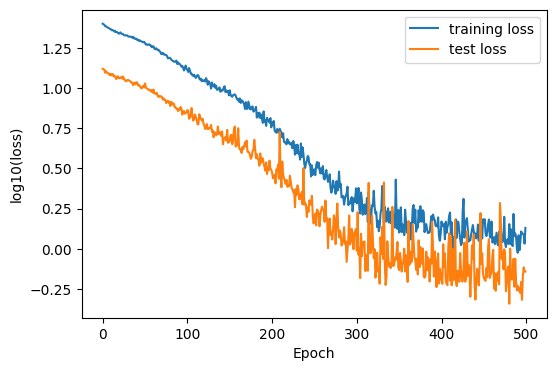

In [13]:
train_loss, test_loss = train(data=(flux_tensor.unsqueeze(dim=1), labels_tensor), model=cnn, n_epoch=500, step=10)

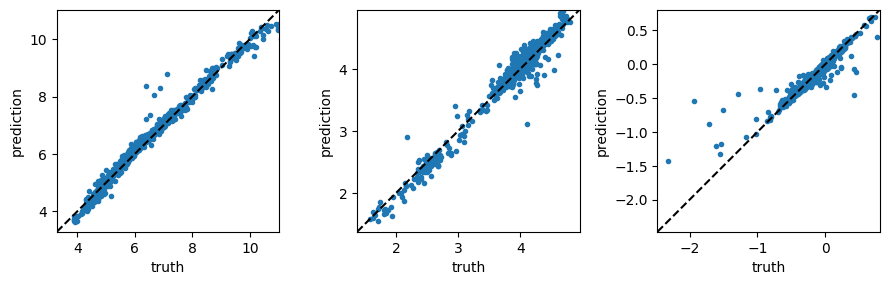

In [14]:
compare_labels(labels_tensor, cnn(flux_tensor.unsqueeze(dim=1)).detach())

In [15]:
flux_tensor.unsqueeze(dim=1).shape

torch.Size([913, 1, 1500])

# 3. Backward model (MLP)

$F_\lambda = f(T_\mathrm{eff}, \log{g}, \mathrm{[Fe/H]})$

In [16]:
mlp_back = nn.Sequential(
    nn.BatchNorm1d(num_features=3),
    nn.Linear(in_features=3, out_features=100),
    nn.BatchNorm1d(num_features=100),
    nn.Tanh(),
    nn.Linear(in_features=100, out_features=NPIX),
)
mlp_back

Sequential(
  (0): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=3, out_features=100, bias=True)
  (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Tanh()
  (4): Linear(in_features=100, out_features=1500, bias=True)
)

Epoch 00000: training loss = 6.87813138961792, test loss = 3.6188547611236572
Epoch 00100: training loss = 3.588930606842041, test loss = 2.0347797870635986
Epoch 00200: training loss = 0.7494157552719116, test loss = 0.3247103691101074
Epoch 00300: training loss = 0.46285584568977356, test loss = 0.3049270212650299
Epoch 00400: training loss = 0.5153937339782715, test loss = 0.21923725306987762
Epoch 00500: training loss = 0.3881043493747711, test loss = 0.32633528113365173
Epoch 00600: training loss = 0.3506585955619812, test loss = 0.15215171873569489
Epoch 00700: training loss = 0.29578810930252075, test loss = 0.15699663758277893
Epoch 00800: training loss = 0.34202495217323303, test loss = 0.16449542343616486
Epoch 00900: training loss = 0.3148233890533447, test loss = 0.18631580471992493
Epoch 01000: training loss = 0.32052162289619446, test loss = 0.18078340590000153
Epoch 01100: training loss = 0.27232399582862854, test loss = 0.1736624538898468
Epoch 01200: training loss = 0.

Sequential(
  (0): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=3, out_features=100, bias=True)
  (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Tanh()
  (4): Linear(in_features=100, out_features=1500, bias=True)
)

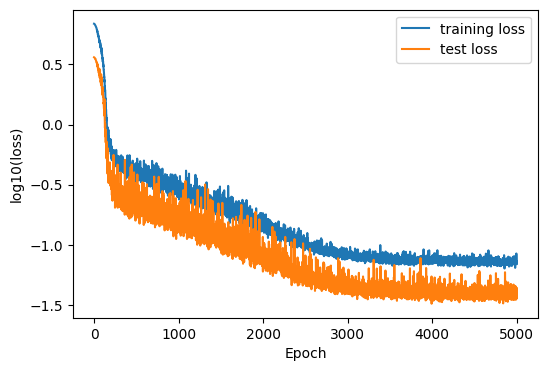

In [17]:
train_loss, test_loss = train(data=(labels_tensor, flux_tensor), model=mlp_back, n_epoch=5000, step=100)
mlp_back.eval()

Populating the interactive namespace from numpy and matplotlib


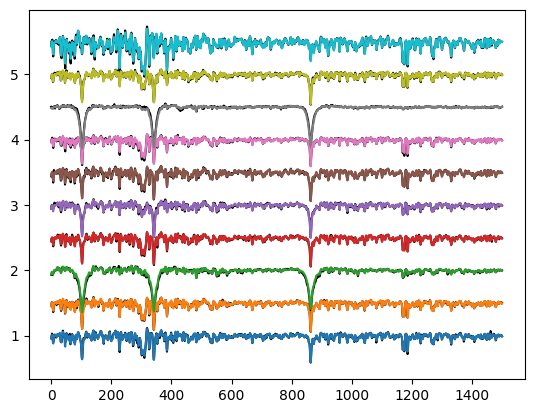

In [18]:
%pylab inline
ofst = 0.5
plt.plot(flux[::100].T+ np.arange(10)[None, :]*ofst, color="k")
plt.plot(mlp_back(labels_tensor[::100]).detach().T + np.arange(10)[None, :]*ofst)

In [19]:
torch.median(mlp_back(labels_tensor[:10]) - flux_tensor[:10], axis=1)

torch.return_types.median(
values=tensor([ 0.0008,  0.0040, -0.0022, -0.0009,  0.0003,  0.0009,  0.0030, -0.0011,
        -0.0029, -0.0022], grad_fn=<MedianBackward1>),
indices=tensor([ 642,  569,   28,  499, 1303, 1440,  771, 1052, 1491, 1415]))

# 4. Autoencoder (MLP)

In [20]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=1500, out_features=100),
            nn.BatchNorm1d(num_features=100),
            nn.Tanh(),
            nn.Linear(in_features=100, out_features=2),
            nn.BatchNorm1d(num_features=2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=2, out_features=100),
            nn.BatchNorm1d(num_features=100),
            nn.Tanh(),
            nn.Linear(in_features=100, out_features=1500)
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [21]:
ae = AE()
print(ae)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=1500, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=100, out_features=2, bias=True)
    (4): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=100, out_features=1500, bias=True)
  )
)


In [22]:
ae.decoder[-1].bias.data = torch.median(flux_tensor, axis=0).values

In [23]:
torch.median(ae.decoder[-1].bias.data)

tensor(0.9879)

Epoch 00000: training loss = 1.947480320930481, test loss = 1.0000931024551392
Epoch 00100: training loss = 0.11075641959905624, test loss = 0.06140074133872986
Epoch 00200: training loss = 0.08698233217000961, test loss = 0.039277929812669754
Epoch 00300: training loss = 0.07827208936214447, test loss = 0.0446169376373291
Epoch 00400: training loss = 0.07611549645662308, test loss = 0.04000069573521614
Epoch 00500: training loss = 0.07084584981203079, test loss = 0.04311260208487511
Epoch 00600: training loss = 0.08214573562145233, test loss = 0.04176117479801178
Epoch 00700: training loss = 0.07642956078052521, test loss = 0.03934846073389053
Epoch 00800: training loss = 0.07382483035326004, test loss = 0.03557107225060463
Epoch 00900: training loss = 0.07403437048196793, test loss = 0.03836384788155556
Epoch 01000: training loss = 0.0699901208281517, test loss = 0.03744998201727867
Epoch 01100: training loss = 0.07242201268672943, test loss = 0.038558464497327805
Epoch 01200: traini

AE(
  (encoder): Sequential(
    (0): Linear(in_features=1500, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=100, out_features=2, bias=True)
    (4): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=100, out_features=1500, bias=True)
  )
)

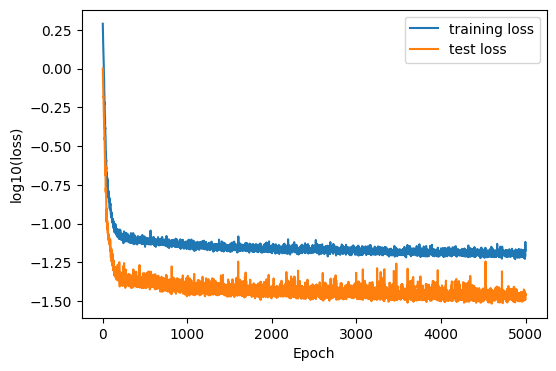

In [24]:
train_loss, test_loss = train(data=(flux_tensor, flux_tensor), model=ae, n_epoch=5000, step=100)
ae.eval()

Populating the interactive namespace from numpy and matplotlib


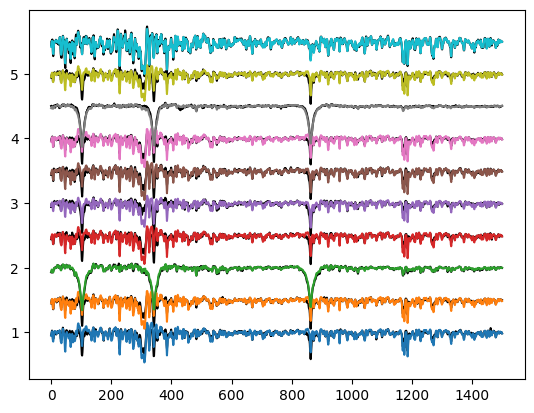

In [25]:
%pylab inline
ofst = 0.5
plt.plot(flux[::100].T+ np.arange(10)[None, :]*ofst, color="k")
plt.plot(ae(flux_tensor[::100]).detach().T + np.arange(10)[None, :]*ofst)

In [26]:
ae

AE(
  (encoder): Sequential(
    (0): Linear(in_features=1500, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=100, out_features=2, bias=True)
    (4): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=100, out_features=1500, bias=True)
  )
)

In [27]:
ae.encoder(torch.rand(size=(10, 1500))).shape

torch.Size([10, 2])

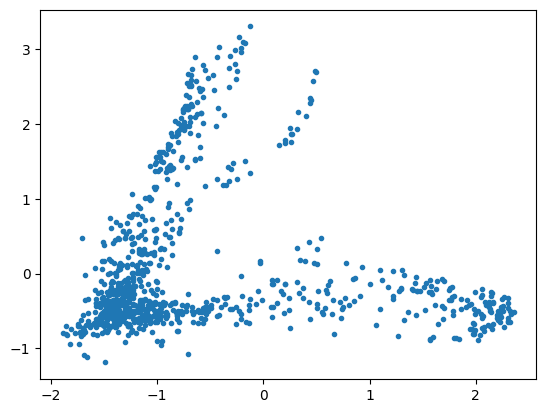

In [28]:
plt.plot(*ae.encoder(flux_tensor).detach().T, '.')

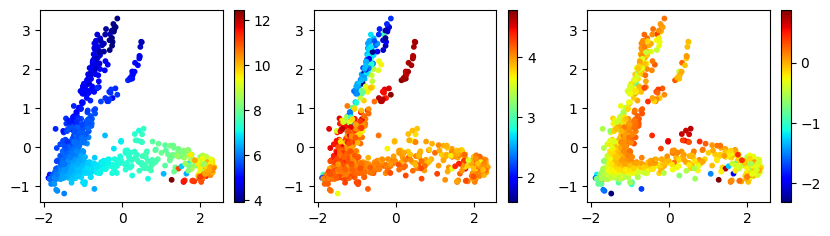

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(10, 2.5))
for idim in range(3):
    h = axs[idim].scatter(*ae.encoder(flux_tensor).detach().T, s=10, c=labels[:,idim], cmap=plt.cm.jet)
    plt.colorbar(mappable=h, ax=axs[idim])